# Windkessel

In [1]:
import numpy as np
import torch

In [2]:
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [4]:
import sys
sys.path.insert(0, './python')

In [5]:
from windkessel import model, utils

In [30]:
patient_id = 123313

### Предобработка

In [31]:
test_model = model.WindkesselModel()

In [32]:
from scipy.integrate import solve_ivp

In [33]:
def plot_x_y(x, y, x_label="x", y_label="y"):
    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(x, y)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [34]:
tp = pd.read_csv(f'data/{patient_id}.csv', header = None, sep = ' ')

In [35]:
# t в секундах, p в мм.рт.ст.
tp = tp.rename({0 :'t', 1: 'p'}, axis = 1)
tp = tp.sort_values(by=['t'])

In [36]:
#Из эксперимента
T = np.array(tp['t'])
P = np.array(tp['p'])

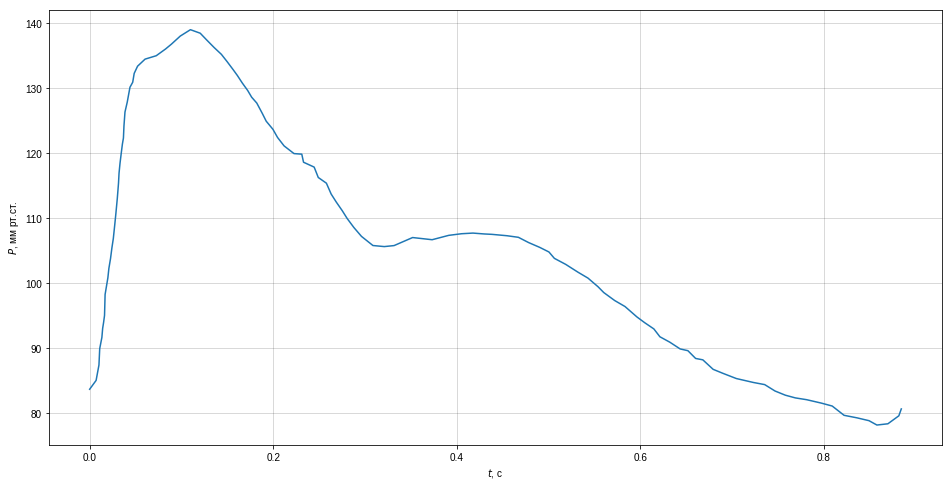

In [37]:
plot_x_y(T, P, "$ t $, с", "$ P $, мм рт.ст.")

#### Сглаживание

In [38]:
# Фильтрация.
n_points = 200
interp1d_params = {}
savgol_filter_params = {"window_length": 9, "polyorder": 3, "mode": "nearest"}

T, P = utils.nonuniform_savgol_filter(T, P, n_points=n_points,
        interp1d_params=interp1d_params, savgol_filter_params=savgol_filter_params)

# Производная.
#savgol_filter_params["deriv"] = 1
#T, der_P = utils.nonuniform_savgol_filter(T, P, n_points=n_points,
#        interp1d_params=interp1d_params, savgol_filter_params=savgol_filter_params)

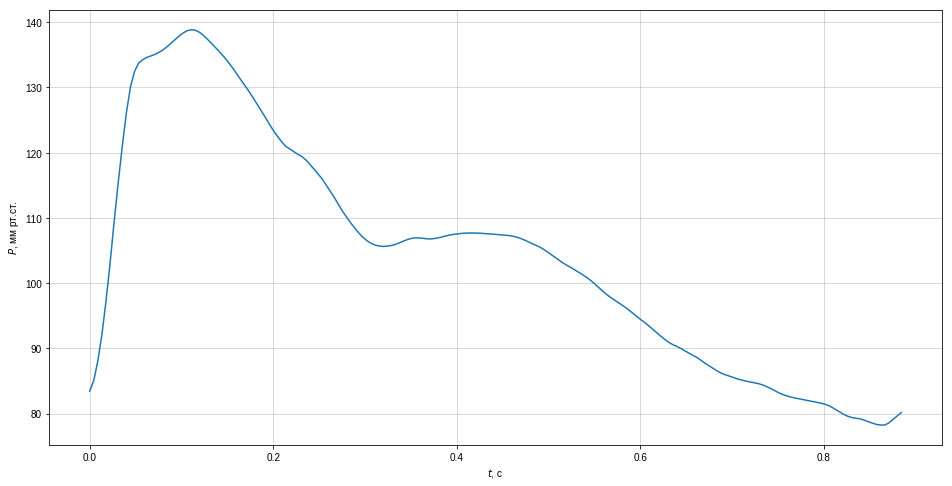

In [39]:
plot_x_y(T, P, "$ t $, с", "$ P $, мм рт.ст.")

In [40]:
test_model.set_P(T, P)#, der_P)

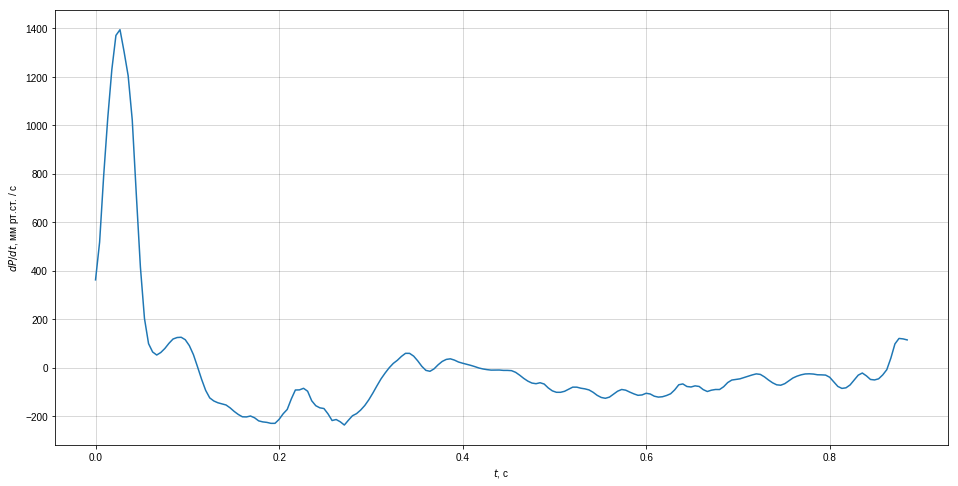

In [41]:
plot_x_y(T, test_model.der_P, "$ t $, с", "$ dP/dt $, мм рт.ст. / с")

#### Получение параметров

In [42]:
P_0, RC, P_out = test_model.get_exp_param()

print("Подобранные параметры: ")
print("P_0:\t%.1f" % P_0)
print("RC:\t%.2f" % RC)
print("P_out:\t%.1f" % P_out)

Подобранные параметры: 
P_0:	105.5
RC:	1.06
P_out:	33.2


### Получение $ Q_{in}(t) $ по $ P(t) $

In [43]:
def Q_in_rhs(t, Q_in):
    return test_model.Q_in_rhs(t, Q_in)#.detach().numpy()

In [44]:
n_cycles = 1
new_T = np.linspace(T[0], T[0] + (T[-1] - T[0]) * n_cycles, T.shape[0] * n_cycles)

In [45]:
result = solve_ivp(Q_in_rhs, (new_T[0], new_T[-1]), np.array([0.0]), t_eval = new_T)

In [46]:
numerical_Q_in = result.y[0]

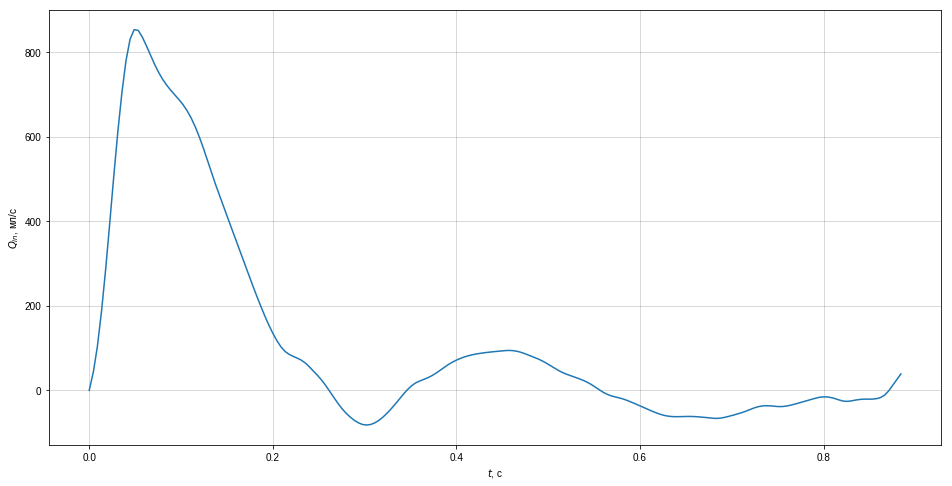

In [47]:
plot_x_y(new_T, numerical_Q_in, "$ t $, с", "$ Q_{in} $, мл/с")

In [48]:
test_model.set_Q_in(new_T, numerical_Q_in)

## LVET

In [49]:
lvet = test_model.get_lvet_LV4()
print(lvet)

0.3465465277976164


In [50]:
op = test_model.get_outflow_pressure_OP3()
print(op)

54.78098283535149


In [51]:
z = test_model.get_impedance_Z3()
print(z)

0.025


In [52]:
print(test_model.R)
R = test_model.get_arterial_resistance_AR2()
print(R)

0.5
0.5978893749847202
